In [116]:
from sqlite3 import Cursor, connect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from util import *
from manually_explore import db_path

mental_health_sql = connect(db_path).cursor()

In [117]:
'''
If you run .schema on the database the result will be:
CREATE TABLE IF NOT EXISTS "Answer" (     
        "AnswerText" VARCHAR(10000) NULL, 
        "SurveyID" INTEGER NULL,
        "UserID" INTEGER NULL,
        "QuestionID" INTEGER NULL
);
CREATE TABLE IF NOT EXISTS "Question" (   
        "questiontext" VARCHAR(1000) NULL,
        "questionid" INTEGER NULL
);
CREATE TABLE IF NOT EXISTS "Survey" (
        "SurveyID" INTEGER NOT NULL,
        "Description" VARCHAR(255) NULL,
        PRIMARY KEY ("SurveyID")
);
CREATE TABLE sqlite_sequence(name,seq);
'''
None

In [118]:
separator = '\n------------------------------\n'

answers_sql = mental_health_sql.execute('Select AnswerText, SurveyID, QuestionID, UserID FROM Answer').fetchall()
answers_df = pd.DataFrame([{'answer': answer[0], 'survey_id': answer[1], 'question_id': answer[2], 'user_id': answer[3]} for answer in answers_sql])
print('Answers:')
print(answers_df.iloc[-5:, :])
print(separator)

questions_sql = mental_health_sql.execute('SELECT questiontext, questionid FROM Question').fetchall()
questions_df = pd.DataFrame([{'question': question[0], 'question_id': question[1]} for question in questions_sql])
print('Questions: ')
print(questions_df.iloc[-5:, :])
print(separator)

surveys_sql = mental_health_sql.execute('SELECT Description, SurveyID FROM Survey').fetchall()
surveys_df = pd.DataFrame([{'survey': survey[0], 'survey_id': survey[1]} for survey in surveys_sql])
print('Surveys:')
print(surveys_df)

mental_health_sql.close()

Answers:
                    answer  survey_id  question_id  user_id
236893               Other       2016          117     2689
236894             Support       2016          117     2690
236895  Back-end Developer       2016          117     2691
236896     DevOps/SysAdmin       2016          117     2692
236897               Other       2016          117     2693

------------------------------

Questions: 
                                              question  question_id
100  Do you think that team members/co-workers woul...          114
101  If yes, what condition(s) have you been diagno...          115
102  If maybe, what condition(s) do you believe you...          116
103  Which of the following best describes your wor...          117
104                              Do you work remotely?          118

------------------------------

Surveys:
                          survey  survey_id
0  mental health survey for 2014       2014
1  mental health survey for 2016       2016
2  m

In [119]:
mental_health = answers_df.merge(questions_df, on='question_id', validate='many_to_one')
mental_health = mental_health.merge(surveys_df, on='survey_id', validate='many_to_one')
mental_health.iloc[-5000:-4995, :]

,answer,survey_id,question_id,user_id,question,survey
231898,-1,2019,75,4147,Describe the conversation your coworker had wi...,mental health survey for 2019
231899,-1,2019,75,4148,Describe the conversation your coworker had wi...,mental health survey for 2019
231900,-1,2019,75,4149,Describe the conversation your coworker had wi...,mental health survey for 2019
231901,-1,2019,75,4150,Describe the conversation your coworker had wi...,mental health survey for 2019
231902,-1,2019,75,4151,Describe the conversation your coworker had wi...,mental health survey for 2019


In [120]:
# Drop answers whose text is "-1"
mental_health_answered = mental_health[mental_health['answer'] != "-1"]
mental_health_answered.iloc[-5000:-4995, :]

,answer,survey_id,question_id,user_id,question,survey
228238,1,2019,65,4007,"Overall, how much importance does your employe...",mental health survey for 2019
228239,5,2019,65,4008,"Overall, how much importance does your employe...",mental health survey for 2019
228240,9,2019,65,4009,"Overall, how much importance does your employe...",mental health survey for 2019
228241,8,2019,65,4010,"Overall, how much importance does your employe...",mental health survey for 2019
228242,0,2019,65,4011,"Overall, how much importance does your employe...",mental health survey for 2019


In [121]:
def cherry_pick_question(df: pd.DataFrame, question_id: int) -> tuple[str, pd.DataFrame]:
    subset = df[df['question_id'] == question_id]
    question_text = subset[['question']].iloc[0, 0]
    return (question_text, subset)

In [122]:
def look_survey_id_from_question_id(question_id: int) -> list[int]:
    _, question_subset = cherry_pick_question(question_id)
    survey_ids = question_subset['survey_id'].unique()
    return list(survey_ids)

def check_if_questions_in_same_survey(question_id: int, question_id1: int) -> bool:
    survey_ids = look_survey_id_from_question_id(question_id)
    survey_ids1 = look_survey_id_from_question_id(question_id1)
    for survey_id in survey_ids:
        if survey_id in survey_ids1:
            return True
    
    return False

Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?


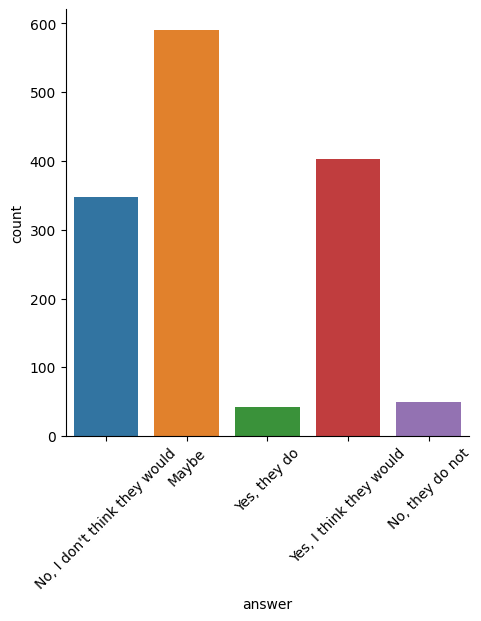

<Figure size 640x480 with 0 Axes>

In [123]:
question_cherry_pick = 114
question, subset = cherry_pick_question(mental_health, question_cherry_pick)

sns.catplot(x='answer', data=subset, kind='count')
print(question)
plt.xticks(rotation=90-45)
plt.show()
plt.clf()

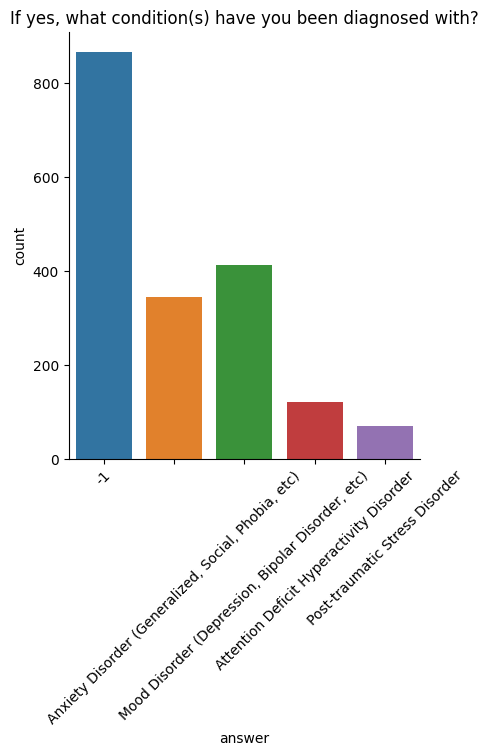

<Figure size 640x480 with 0 Axes>

In [124]:
question_cherry_pick = 115
question, subset = cherry_pick_question(mental_health, question_cherry_pick)

# Select the 5 most popular responses and update subset
counts = subset['answer'].value_counts()
nlargest = counts.nlargest(5)
subset = subset[subset['answer'].isin(nlargest.index)]
diagnosed_conditions = subset

sns.catplot(x='answer', data=diagnosed_conditions, kind='count', )
plt.title(question)
plt.xticks(rotation=90-45)
plt.show()
plt.clf()

In [125]:
question_cherry_pick = 118
_, works_remotely_answers = cherry_pick_question(mental_health, question_cherry_pick)
works_remotely_answers['answer'].value_counts()

Sometimes    757
Always       343
Never        333
Name: answer, dtype: int64

In [126]:
user_works_remotly_dict = {}
for _, answer in works_remotely_answers.iterrows():
    user_works_remotly_dict[answer['user_id']] = answer['answer']

works_remotely_dataframe = pd.DataFrame(data={'user_id': user_works_remotly_dict.keys(), 'works_remote': user_works_remotly_dict.values()})
works_remotely_dataframe.head()

,user_id,works_remote
0,1261,Sometimes
1,1262,Never
2,1263,Always
3,1264,Sometimes
4,1265,Sometimes


In [127]:
mental_health_works_remote = mental_health.merge(works_remotely_dataframe, on='user_id')
mental_health_works_remote.head()

,answer,survey_id,question_id,user_id,question,survey,works_remote
0,39,2016,1,1261,What is your age?,mental health survey for 2016,Sometimes
1,Male,2016,2,1261,What is your gender?,mental health survey for 2016,Sometimes
2,United Kingdom,2016,3,1261,What country do you live in?,mental health survey for 2016,Sometimes
3,-1,2016,4,1261,"If you live in the United States, which state ...",mental health survey for 2016,Sometimes
4,0,2016,5,1261,Are you self-employed?,mental health survey for 2016,Sometimes


In [128]:
question_cherry_pick = 115
question, subset = cherry_pick_question(mental_health_works_remote, question_cherry_pick)
subset = subset.dropna(subset='works_remote', inplace=False)
group_by_remote_counts = subset.dropna(subset='works_remote', inplace=False).groupby('works_remote')['answer'].value_counts(normalize=False, ascending=False)
group_by_remote_counts

works_remote  answer                                                    
Always        -1                                                            209
              Mood Disorder (Depression, Bipolar Disorder, etc)              92
              Anxiety Disorder (Generalized, Social, Phobia, etc)            84
              Attention Deficit Hyperactivity Disorder                       30
              Obsessive-Compulsive Disorder                                  15
                                                                           ... 
Sometimes     Pervasive Developmental Disorder (Not Otherwise Specified)      1
              Schizotypal Personality Disorder                                1
              Sexual addiction                                                1
              Transgender                                                     1
              Traumatic Brain Injury                                          1
Name: answer, Length: 61, dtype: int64

In [129]:
works_remote_list = []
diagnosis = []

row_count = 5
for counts_index in group_by_remote_counts.index:
    diagnostic = counts_index[1]
    if diagnostic == '-1':
        diagnostic = 'Nothing'
    works_remote = counts_index[0]

    works_remote_list.append(works_remote)
    diagnosis.append(diagnostic)
    
works_remote_diagnosis_frame = pd.DataFrame(data={'works_remote': works_remote_list, 'diagnosis': diagnosis, 'count': group_by_remote_counts.values})
works_remote_diagnosis_frame.head()

,works_remote,diagnosis,count
0,Always,Nothing,209
1,Always,"Mood Disorder (Depression, Bipolar Disorder, etc)",92
2,Always,"Anxiety Disorder (Generalized, Social, Phobia,...",84
3,Always,Attention Deficit Hyperactivity Disorder,30
4,Always,Obsessive-Compulsive Disorder,15


In [130]:
most_common_diagnotics = list(works_remote_diagnosis_frame[works_remote_diagnosis_frame['works_remote'] == 'Always']['diagnosis'])[:row_count]
works_remote_most_common_diagnosis_frame = works_remote_diagnosis_frame[works_remote_diagnosis_frame['diagnosis'].isin(most_common_diagnotics)]
works_remote_most_common_diagnosis_frame.head()

,works_remote,diagnosis,count
0,Always,Nothing,209
1,Always,"Mood Disorder (Depression, Bipolar Disorder, etc)",92
2,Always,"Anxiety Disorder (Generalized, Social, Phobia,...",84
3,Always,Attention Deficit Hyperactivity Disorder,30
4,Always,Obsessive-Compulsive Disorder,15


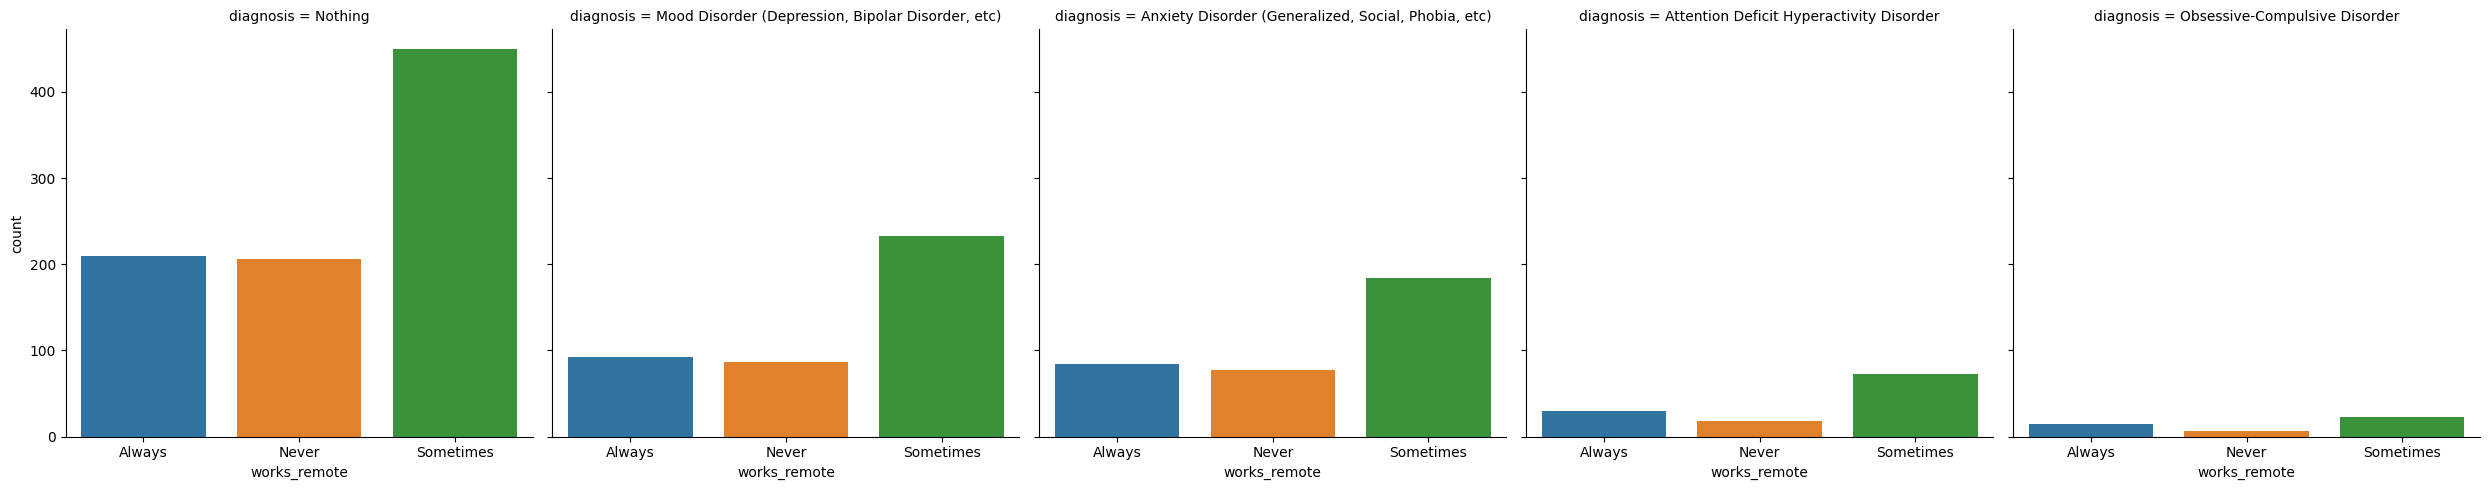

works_remote
Sometimes       0.545367
Always          0.235039
Never           0.219595
dtype: float64

<Figure size 640x480 with 0 Axes>

In [131]:
sns.catplot(x='works_remote', y='count', col='diagnosis', data=works_remote_most_common_diagnosis_frame, kind='bar')
plt.show()
plt.clf()
diagnosis_works_remote_value_counts = subset.value_counts(subset=['works_remote'], normalize=True)
diagnosis_works_remote_value_counts

As the group of people that sometimes works remotely is bigger than the other 2 combined I'll multiply the count value by the mean of the other two works_remote_answers so there will be an approximation of the same population

In [132]:
works_remote_possible_answers = [index[0] for index in diagnosis_works_remote_value_counts.index]
works_remote_answered_diagnosis_normaliced_count = list(diagnosis_works_remote_value_counts.values)
works_remote_answered_diagnosis_normaliced_count_frame = pd.DataFrame({'works_remote': works_remote_possible_answers, 'works_remote_normaliced_count': works_remote_answered_diagnosis_normaliced_count})
print(works_remote_answered_diagnosis_normaliced_count_frame.head())

print(separator)

works_remote_most_common_diagnosis_frame = works_remote_most_common_diagnosis_frame.merge(works_remote_answered_diagnosis_normaliced_count_frame, on='works_remote', validate='many_to_one')
print(works_remote_most_common_diagnosis_frame.head())

print(separator)

works_remote_most_common_diagnosis_frame['adjusted_count'] = works_remote_most_common_diagnosis_frame['count'] * (1 - works_remote_most_common_diagnosis_frame['works_remote_normaliced_count'])

adjusted_count = {'works_remote': [], 'adjusted_count': []}
for i, works_remote_answer in enumerate(works_remote_possible_answers):
    others_mean = np.mean([works_remote_answered_diagnosis_normaliced_count[j] for j in range(len(works_remote_possible_answers)) if j != i])


if 'works_remote_normaliced_count' in works_remote_most_common_diagnosis_frame.columns:
    works_remote_most_common_diagnosis_frame.drop(labels='works_remote_normaliced_count', inplace=True, axis='columns')

works_remote_most_common_diagnosis_frame.head()

  works_remote  works_remote_normaliced_count
0    Sometimes                       0.545367
1       Always                       0.235039
2        Never                       0.219595

------------------------------

  works_remote                                          diagnosis  count  \
0       Always                                            Nothing    209   
1       Always  Mood Disorder (Depression, Bipolar Disorder, etc)     92   
2       Always  Anxiety Disorder (Generalized, Social, Phobia,...     84   
3       Always           Attention Deficit Hyperactivity Disorder     30   
4       Always                      Obsessive-Compulsive Disorder     15   

   works_remote_normaliced_count  
0                       0.235039  
1                       0.235039  
2                       0.235039  
3                       0.235039  
4                       0.235039  

------------------------------



,works_remote,diagnosis,count,adjusted_count
0,Always,Nothing,209,159.876931
1,Always,"Mood Disorder (Depression, Bipolar Disorder, etc)",92,70.376448
2,Always,"Anxiety Disorder (Generalized, Social, Phobia,...",84,64.256757
3,Always,Attention Deficit Hyperactivity Disorder,30,22.948842
4,Always,Obsessive-Compulsive Disorder,15,11.474421


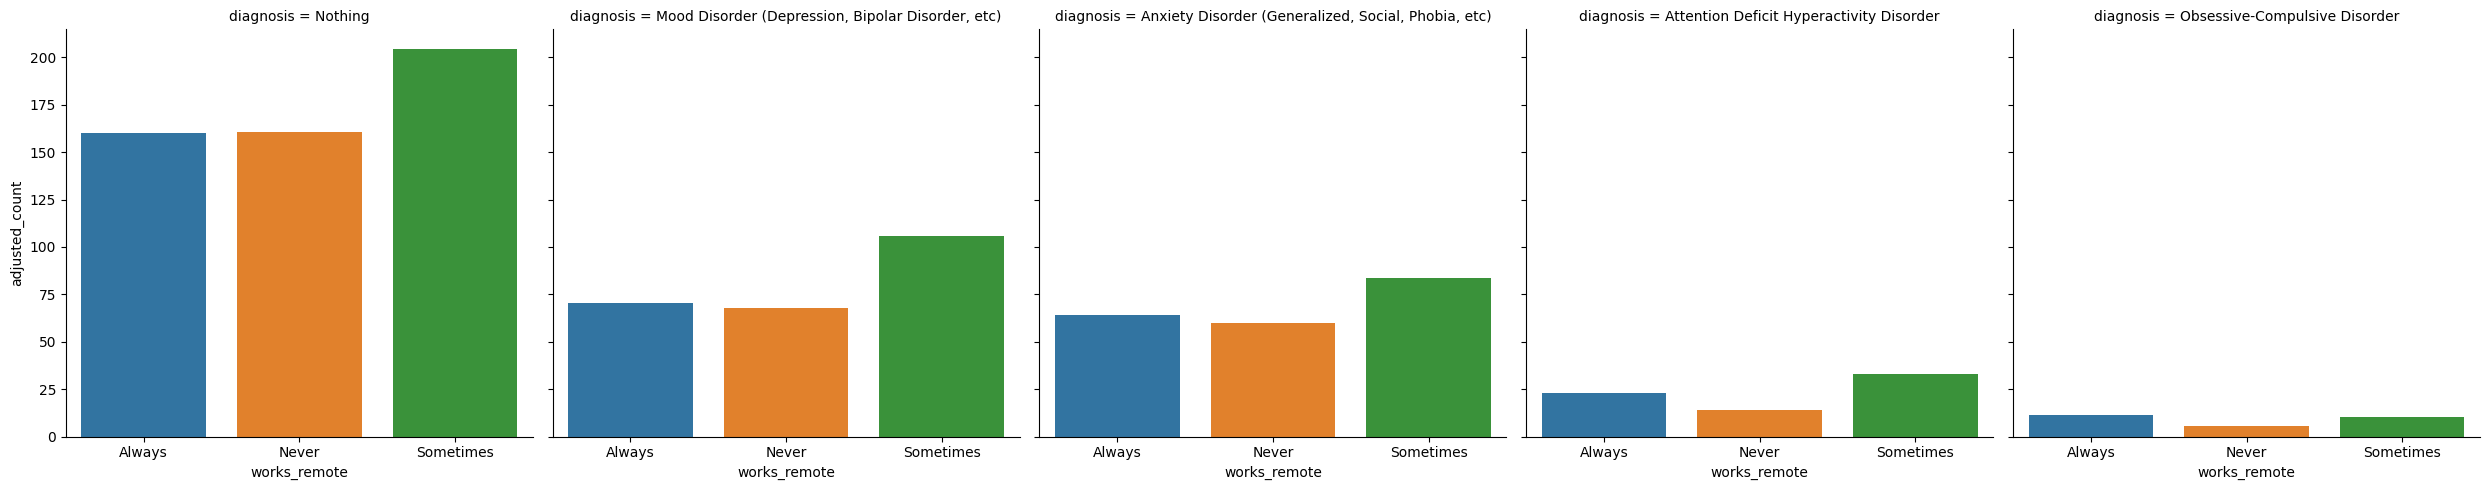

<Figure size 640x480 with 0 Axes>

In [133]:
sns.catplot(x='works_remote', y='adjusted_count', col='diagnosis', kind='bar', data=works_remote_most_common_diagnosis_frame)
plt.show()
plt.clf()

Since there obiously are more people that sometimes work remote than the other two groups the conclusions that I can draw are limited:
Limitations:
* The proportion of people that always and never work remote is the same.
* The proportion of people that sometimes work remote is more than the other two combined or more than the double of the other ones.
 
Conclusions:
* People that sometimes works remote tend to have less chance of Obsessive-Compulsive disorder.
* People that never work remote tend to have less Obsessive-Compulsive disorder, Mood disorder by a slight difference, the same happens with Anxiety Disorder, there is a higher difference with Attention deficit.

# Objective
## Visualice how well does people think the tech industry supports employees with mental health issues? (Question 85)

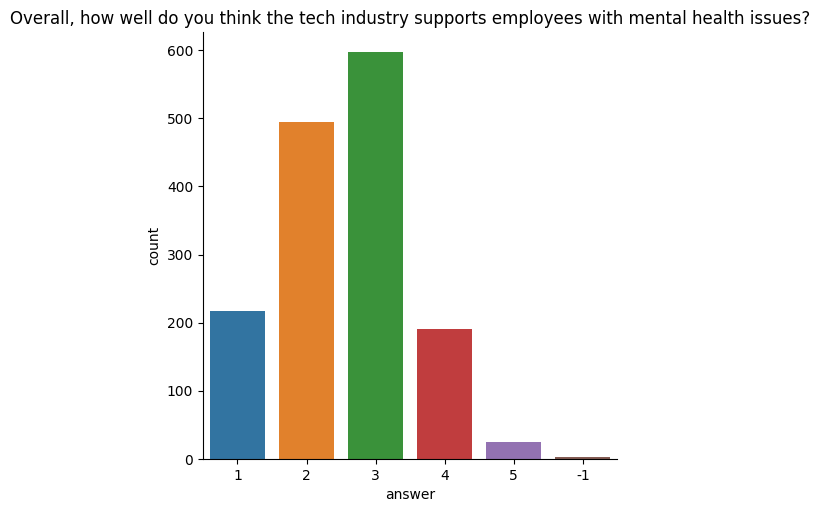

answer mean: 2.5429508196721313


<Figure size 640x480 with 0 Axes>

In [134]:
question_cherry_pick = 85
question, subset = cherry_pick_question(mental_health, question_cherry_pick)
sns.catplot(x='answer', kind='count', data=subset)
plt.title(question)
plt.show()
plt.clf()
print('answer mean:', subset['answer'].astype('int8').mean())

### Result
As plot and mean shows the output is shifted towards a feeling of bad support to 

# Objective
## Know if people have resources to seek help for mental health issues and see both results differentiating people that have or not a mental health issue

Do you know local or online resources to seek help for a mental health issue?


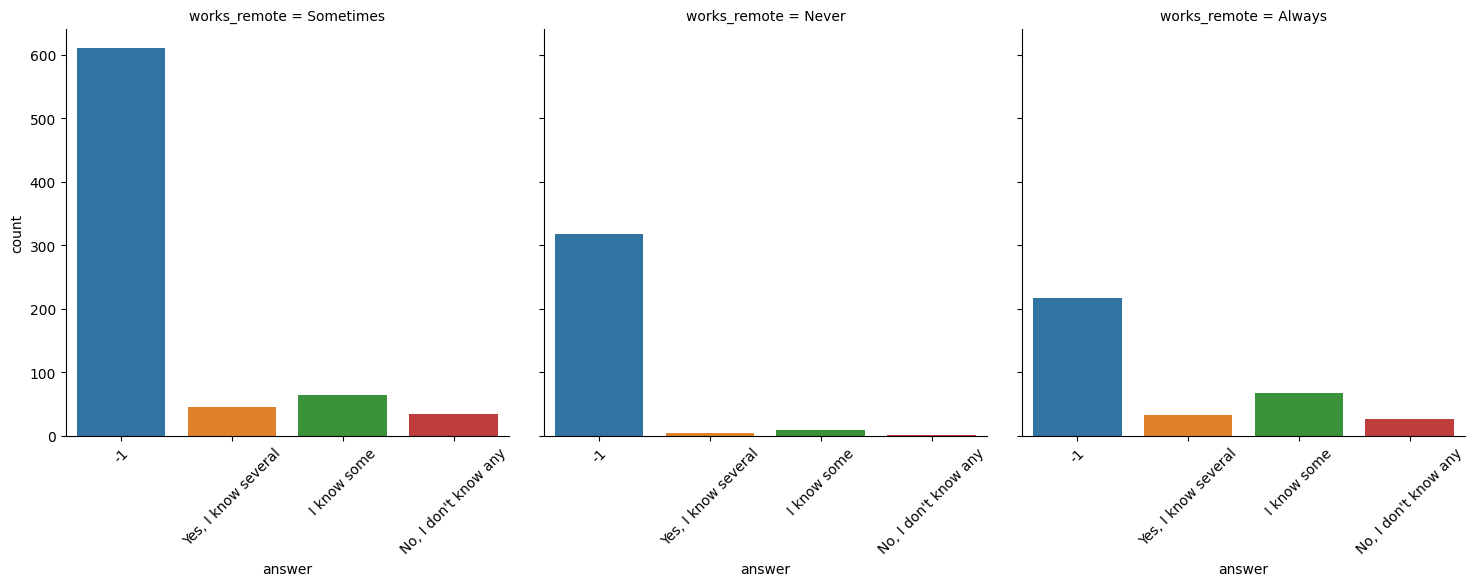

<Figure size 640x480 with 0 Axes>

In [142]:
question_cherry_pick = 21
question, subset = cherry_pick_question(mental_health_works_remote, question_cherry_pick)

print(question)
g = sns.catplot(x='answer', col='works_remote', kind='count', data=subset)
g: sns.FacetGrid
g.set_xticklabels(rotation=90-45)
plt.show()
plt.clf()

### Result

People who never work remote has a lower indice of mental health conditions compared to, for example, people who always work remote.